The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

In [1]:
# Upload Kagle Token

from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# Create the Kaggle folder & Move the Kaggle token file into it

import os
import shutil

kaggle_dir = '/root/.kaggle'

if not os.path.exists(kaggle_dir):
  os.makedirs(kaggle_dir)

source = '/content/kaggle.json'
destination = '/root/.kaggle/kaggle.json'

if os.path.exists(source):
  shutil.move(source, destination)

In [3]:
# Change permissions to the Kaggle token file

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle site

# URL of the page: https://www.kaggle.com/datasets/sergylog/ab-test-data/data

!kaggle datasets download -d sergylog/ab-test-data/data

Dataset URL: https://www.kaggle.com/datasets/sergylog/ab-test-data/versions/data
License(s): Community Data License Agreement - Sharing - Version 1.0
400 - Bad Request - Invalid datasetVersionNumber value


Let's import the necessary libraries and load the data

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [11]:
#Load the data
from google.colab import files
uploaded = files.upload()

Saving AB_Test_Results.csv to AB_Test_Results (1).csv


In [12]:
# Take a quick look at the data
path = '/content/AB_Test_Results.csv'
df = pd.read_csv(path)

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [13]:
# Look at the distribution of the number of unique groups for each user
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


In [14]:
# Look at the distribution of the number of unique groups for each user in relative terms
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [17]:
# taking look at the distribution of the number of unique groups for each user
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

,count
VARIANT_NAME,
1,4783
2,1541


In [16]:
# also look in relative terms %
double_variant_count / double_variant_count.sum()

,count
VARIANT_NAME,
1,0.756325
2,0.243675


What can you observe ? Should we exclude these users ? Why ?

In [18]:
# TODO : users have 1 A/B test group ?
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
# TODO : Take only these users
single_variant_users = single_variant_users[single_variant_users]

In [19]:
# TODO : Leave only records with users with the 1st ab test group
df = df[df['USER_ID'].isin(single_variant_users.index)]
# TODO : Check that the number of users matches what it was before the exception
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

Let's see how the data is distributed

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

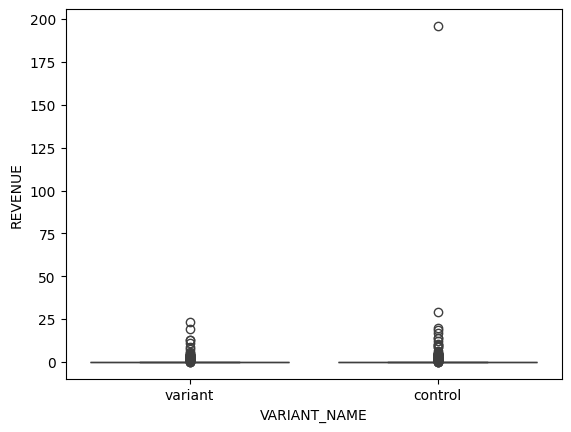

In [20]:
# Check how the data is distributed using a box plot
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [21]:
# Sort these revenue values in descending order
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [22]:
# See if user 3342 had other events with a strong outlier
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [23]:
# We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df = df[df['USER_ID'] != 3342]


([<matplotlib.axis.XTick at 0x7c8fcc404400>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

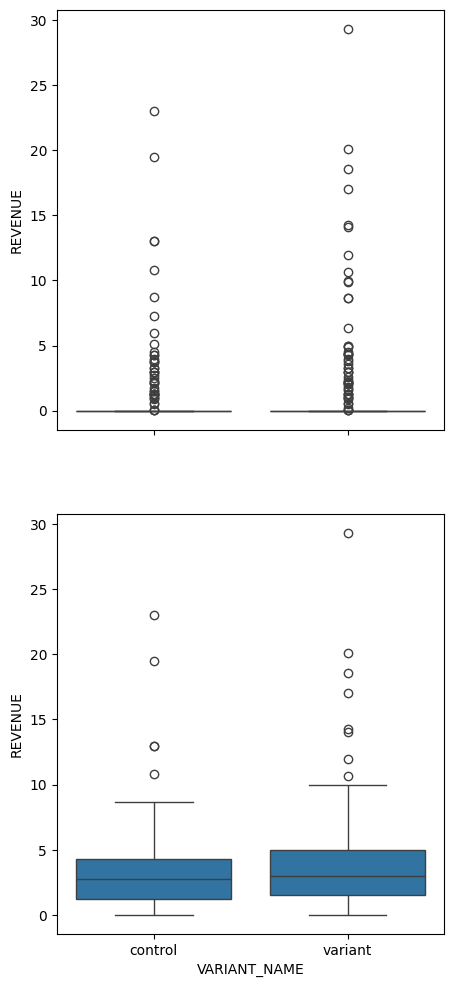

In [24]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))


What can you say about the users and their purchases ?

In [25]:
# Check if there are users who have records with zero and positive revenue
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
]).count()

52

Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [26]:
# Group the data for each user and sum the revenue for each to get one record per user
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

([<matplotlib.axis.XTick at 0x7c8fcc30d8d0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

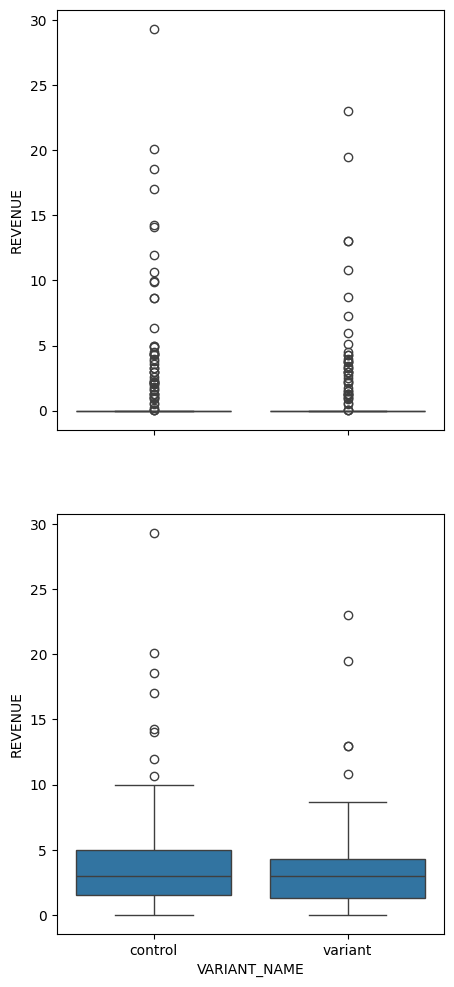

In [27]:
# Visualize the resulting distribution of the data again.
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [28]:
# Get metrics by groups
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# Create two additional metrics to see relative changes
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# Add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

Let's look at the distributions of all and only paying users

In [30]:
# get metrics by groups
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

# add two additional metrics to see relative changes
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

<ipython-input-29-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-29-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

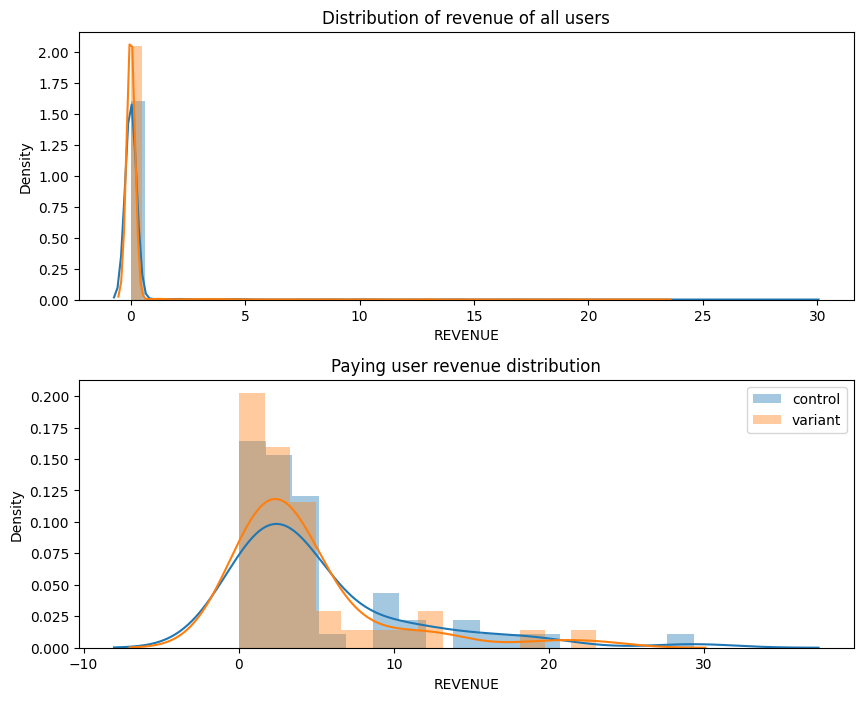

In [29]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [31]:
# Use the Shapiro-Wilk criterion to confirm it
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145986897942335, pvalue=9.962810723092505e-76)

Is the null hypothesis about the normal distribution of the data rejected ?

The null hypothesis about the normal distribution of the data is rejected

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [32]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [33]:
# Check on the data of all users the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

In [34]:
# Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'],
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [35]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [36]:
# Generate samples for all users
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [37]:
# Generate samples for only paying users
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

<ipython-input-38-981be6013529>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
<ipython-input-38-981be6013529>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

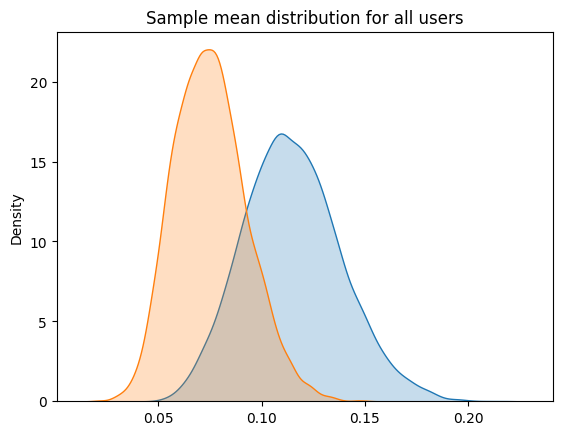

In [38]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

<ipython-input-39-fefa5149434d>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
<ipython-input-39-fefa5149434d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

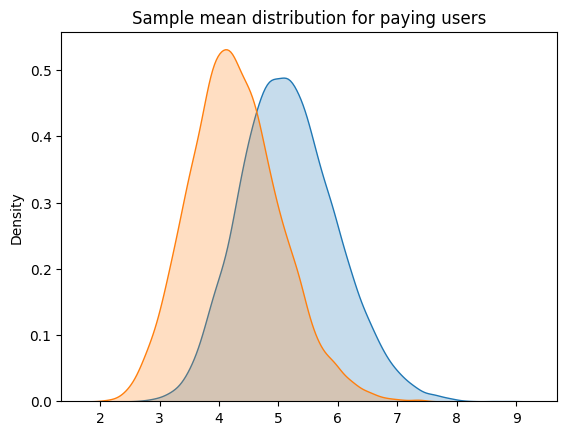

In [39]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [40]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

<ipython-input-40-5240a9893e8d>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


IndexError: list index out of range

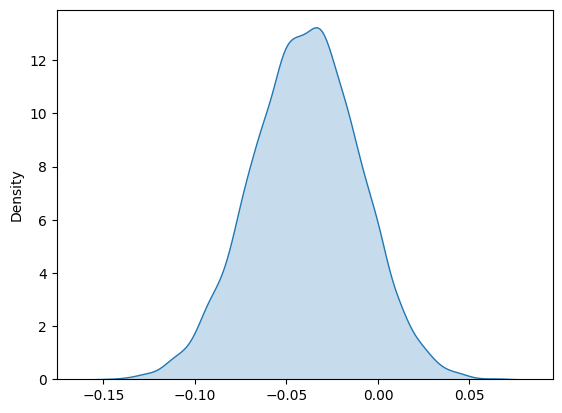

In [42]:
plot_distribution_and_stat_intervals(
    np.mean(variant, axis=1),
    np.mean(control, axis=1),
    title='all users'
)

In [43]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals

    # Calculate the difference beforehand
    diff = variant - control

    # Check if the difference is valid and not empty
    if len(diff) > 0:
        kdeplot_result = sns.kdeplot(diff, shade=True)

        # Check if lines were generated
        if len(kdeplot_result.get_lines()) > 0:
            points = kdeplot_result.get_lines()[0].get_data()
            x = points[0]
            y = points[1]
            ymin, ymax = plt.ylim()
            # highlight the zero value and the bounds of the confidence interval
            plt.vlines(0, 0, ymax, label='0', color='gray')
            plt.vlines(stat_intervals(diff, alpha)[0], 0, ymax, linestyles="dashed")
            plt.vlines(stat_intervals(diff, alpha)[1], 0, ymax, linestyles="dashed")
            # color the confidence interval and zones outside it
            plt.fill_between(x,y,
                             where = (x >= stat_intervals(diff, alpha)[1]),
                             color='gainsboro')
            plt.fill_between(x,y,
                             where = (x <= stat_intervals(diff, alpha)[0]),
                             color='gainsboro')
            plt.fill_between(x,y,
                             where = ((x >= stat_intervals(diff, alpha)[0])
                                      & (x <= stat_intervals(diff, alpha)[1])),
                             color='red',
                             label = '95% confidence interval')
            plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(diff, alpha)}')
            plt.legend(prop={'size':13})
            # return confidence interval data
            return stat_intervals(diff)
        else:
            print("Warning: No lines were generated by kdeplot.")
    else:
        print("Warning: The difference between variant and control is empty.")

<ipython-input-43-e2271e6238f8>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot_result = sns.kdeplot(diff, shade=True)


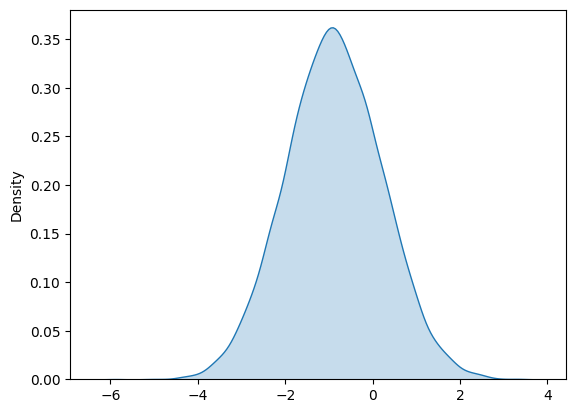

In [44]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


Users with two ab test groups were excluded in order to make the effect of the changes more pronounced User_id=3342 was excluded, because in conditions of limited information it is a strong outlier in the received sample Users are taken as the experimental unit, and then the data is grouped by each user and revenue and summed over each to get one record per user Despite the fact that the revenue in the test group decreased significantly, there were no statistically significant changes between the ab test groups, both among all users and among only the paying audience. For a deeper analysis, the data of the A / A test and further study of the power of the criteria will be useful.